# 7.1.7 Predicción de la resistencia del concreto usando redes neuronales

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../../../../../") 

from utils.paths import make_dir_line

modality = 'u'
project = 'Analitica predictiva'
data = make_dir_line(modality, project)

raw = data('raw')

## 7.1.7.1 Contexto

El concreto es uno de los materiales más usados en construcción. Es fabricado por la mezcla de varios elementos, la cual, al secarse, forma una masa dura muy resistente a la compresión. Uno de los principales problemas es que la mezcla puede demorarse varios meses en secar, y resulta particularmente importante el poder realizar pronósticos de la resistencia que alcanzará, tanto para fines de control como para verificar las restricciones de diseño.

La muestra contiene 1030 mediciones de concretos con ocho características que decriben los componentes usados en la mezcla. Se piensa que estas ocho características tienen una relación no lineal con la resistencia a la compresión final que tiene el concreto.

Se desea construir un modelo de redes neuronales usando las siguientes variables.

- Cement (component 1) [Cemento] – quantitative – kg in a m3 mixture – Input Variable
- Bla st Furnace Slag [Ceniza] (component 2) – quantitative – kg in a m3 mixture – Input Variable
- Fly Ash (component 3) [Ceniza] – quantitative – kg in a m3 mixture – Input Variable
- Water (component 4) [Agua] – quantitative – kg in a m3 mixture – Input Variable
- Superplasticizer (component 5) [Plastificador] – quantitative – kg in a m3 mixture – Input Variable
- Coarse Aggregate (component 6) [Agregado grueso] – quantitative – kg in a m3 mixture – Input Variable
- Fine Aggregate (component 7) [Agregado fino] – quantitative – kg in a m3 mixture – Input Variable
- Age – quantitative – Day (1~365) [Edad] – Input Variable
- Concrete compressive strength [Resistencia a la compresión] – quantitative – MPa – Output Variable

## 7.1.7.2 Load data and pipeline

In [4]:
df = pd.read_csv(
    raw / "concrete.csv",
)

df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


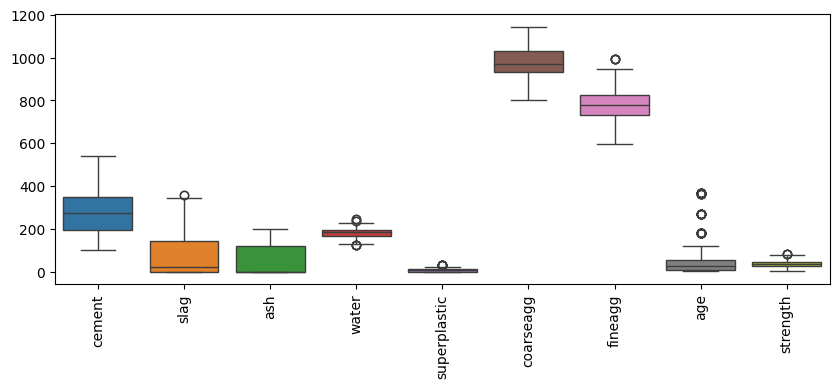

In [5]:
#
# Los rangos de las variables numéricas son bastantes diferentes
#
plt.figure(figsize=(10, 3.5))
sns.boxplot(data=df)
plt.xticks(rotation=90);

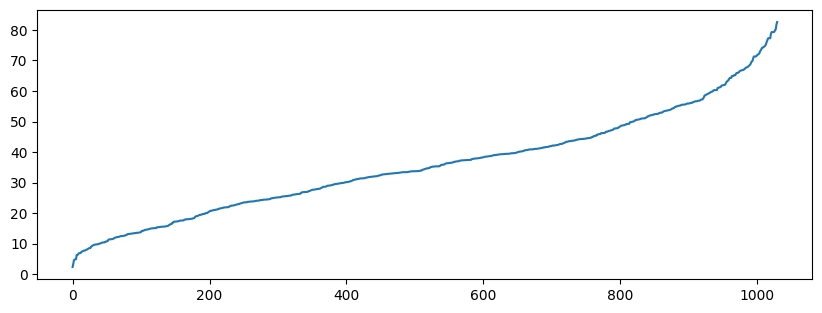

In [6]:
plt.figure(figsize=(10, 3.5))
plt.plot(df.strength.sort_values().to_list())
plt.show()

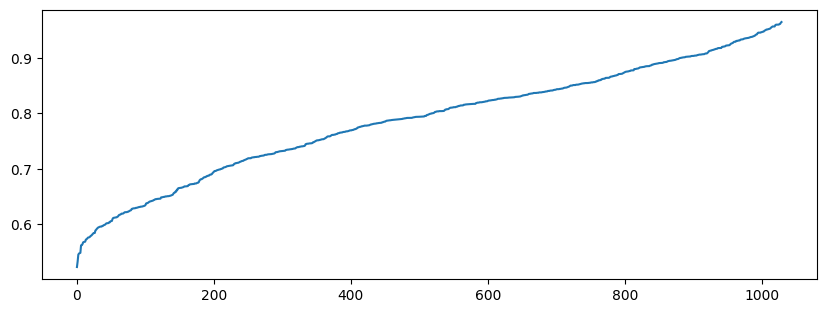

In [7]:
plt.figure(figsize=(10, 3.5))
plt.plot(
    df.strength.map(lambda y: np.exp(0.04 * y) / (1 + np.exp(0.04 * y)))
    .sort_values()
    .to_list()
)
plt.show()

In [8]:
# Crear el pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),          # Escalar los datos
    ('selector', SelectKBest(f_regression, k=2)), # Seleccionar las mejores características
    ('regressor', MLPRegressor())         # Usar un regresor MLP
])

In [9]:
# from sklearn.compose import TransformedTargetRegressor

# transformedTargetRegressor = TransformedTargetRegressor(
#     regressor=pipeline,
#     func=lambda z: np.exp(0.04 * z) / (1 + np.exp(0.04 * z)),
#     inverse_func=lambda z: np.log(1 / (1 - z)) / 0.04,
#     check_inverse=False,
# )

In [10]:
# Definir los parámetros para GridSearchCV
param_grid = {
    'selector__k': [1, 2, 3],  # Puedes ajustar el rango según tus necesidades
    'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'regressor__alpha': [0.0001, 0.001, 0.01],
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error', refit=True, n_jobs=-1)

## 7.1.7.3 fit model

In [11]:
# Separar características (X) y etiquetas (y)
X = df.drop('strength', axis=1)
y = df['strength']

In [12]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('selector',
                                        SelectKBest(k=2,
                                                    score_func=<function f_regression at 0x0000029E954E1800>)),
                                       ('regressor', MLPRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.0001, 0.001, 0.01],
                         'regressor__hidden_layer_sizes': [(50,), (100,),
                                                           (50, 50)],
                         'selector__k': [1, 2, 3]},
             scoring='neg_mean_squared_error')

In [14]:
# Obtener las variables importantes seleccionadas por SelectKBest
selected_features = X.columns[grid_search.best_estimator_.named_steps['selector'].get_support()]

In [15]:
# Hacer predicciones en los conjuntos de entrenamiento y prueba
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

In [16]:
# Calcular las métricas de evaluación
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir resultados
print('Variables importantes seleccionadas:', selected_features)
print(f'Mean Squared Error (Train): {mse_train}')
print(f'Mean Squared Error (Test): {mse_test}')
print(f'R2 Score (Train): {r2_train}')
print(f'R2 Score (Test): {r2_test}')

Variables importantes seleccionadas: Index(['cement', 'superplastic', 'age'], dtype='object')
Mean Squared Error (Train): 145.70318202196893
Mean Squared Error (Test): 116.8802030008084
R2 Score (Train): 0.4871166439888682
R2 Score (Test): 0.5464079024639708


In [17]:
def plot_forecasts(y_true, y_pred):
    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(y_true, y_pred, color="tab:blue", alpha=0.8, edgecolors="white")
    plt.xlabel("y true")
    plt.ylabel("y pred")
    x_ = np.linspace(*plt.gca().get_xlim())
    plt.gca().plot(x_, x_, "k-")
    plt.gca().spines["left"].set_color("gray")
    plt.gca().spines["bottom"].set_color("gray")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.plot()

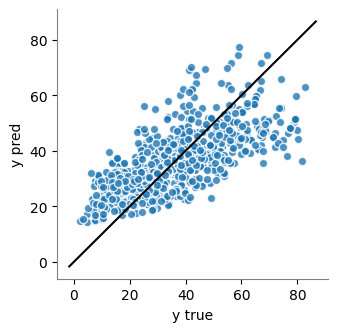

In [18]:
plot_forecasts(y_train, y_train_pred)

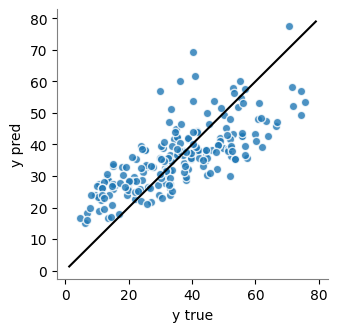

In [19]:
plot_forecasts(y_test, y_test_pred)

In [20]:
print('ok_')

ok_
